In [1]:
from reservoir_rls_multires import *
import matplotlib.pyplot as plt
from lorenz63 import *
from scipy.signal import welch, periodogram, detrend
from sklearn.preprocessing import StandardScaler
from scipy.stats import sem
from scipy.interpolate import interp1d
from scipy.special import expit
import cma
import pandas as pd

# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

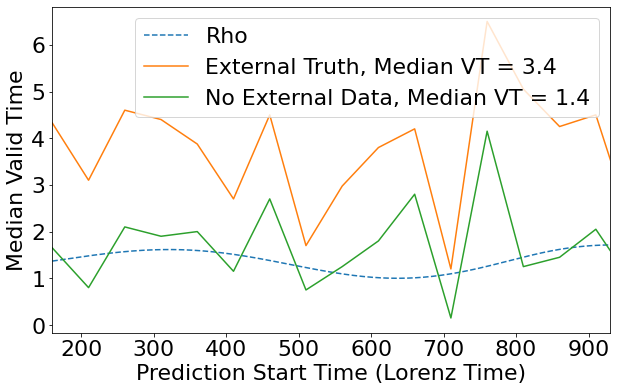

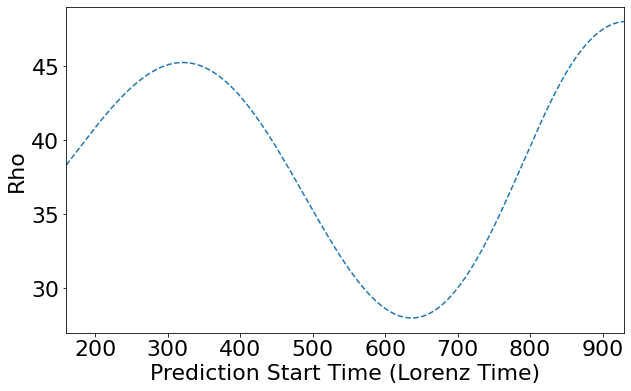

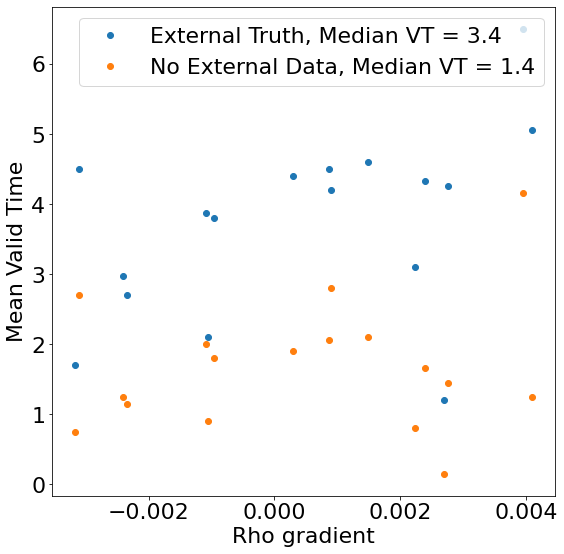

In [28]:
results_file_extern   = 'rossler_external_truth_results.csv'
results_file_noextern = 'rossler_noexternal_results.csv'
results_file_filter   = 'rossler_external_filtered_results.csv'
rho_file     = 'rossler_rho.csv'
step = 0.05
valid_times_extern  = np.loadtxt(results_file_extern, delimiter = ',')*step
extern_rows       = np.all(valid_times_extern != 0., axis = 1)
valid_times_extern  = valid_times_extern[extern_rows]
valid_times_noextern  = np.loadtxt(results_file_noextern, delimiter = ',')*step
noextern_rows         = np.all(valid_times_noextern != 0., axis = 1)
valid_times_noextern  = valid_times_noextern[noextern_rows]
valid_times_filter  = np.loadtxt(results_file_filter, delimiter = ',')*step
extern_filt_rows       = np.all(valid_times_filter != 0., axis = 1)
valid_times_filter  = valid_times_filter[extern_filt_rows]

rhos                  = np.loadtxt(rho_file, delimiter = ',')
median_vt_extern      = np.median(valid_times_extern, axis = 0)
median_vt_noextern    = np.median(valid_times_noextern, axis = 0)
median_vt_filter      = np.median(valid_times_filter, axis = 0)

num_tests    = median_vt_extern.size
init_delay   = 0
filter_delay = 2460
data_step_noextern = 20000//num_tests
data_step    = (20000-init_delay)//num_tests
init_delay_filt = 2000
data_step_filt = (20000-init_delay_filt-filter_delay)//num_tests
prepred_len  = 3000+200
times = (np.arange(num_tests)*data_step+prepred_len+init_delay)*step
times_filt = (np.arange(num_tests)*data_step_filt+prepred_len+init_delay_filt)*step
times_noextern = (np.arange(num_tests)*data_step_noextern+prepred_len)*step
xbegin = 160
xend  = 930

plotrhos = ((rhos-(np.max(rhos)+np.min(rhos))/2)/(np.max(rhos)-np.min(rhos))*(48/28-1)+(1+(48/28-1)/2))

fig = plt.figure(figsize = (10,6))
plt.plot(np.arange(rhos.size)*step, plotrhos, '--',label = 'Rho')
plt.plot(times, median_vt_extern, label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
# plt.plot(times_filt, median_vt_filter, label = 'External filtered z, Median VT = %0.1f' % np.median(valid_times_filter))
plt.plot(times_noextern, median_vt_noextern, label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Median Valid Time')
plt.xlim(xbegin,xend)
plt.legend()
plt.savefig('lorenz_rossler_median_vt_wextern.png')
plt.show()

fig2 = plt.figure(figsize = (10,6))
plt.plot(np.arange(rhos.size)*step, plotrhos*28, '--',label = 'Rho')
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Rho')
plt.savefig('rho_values_rossler.png')
plt.xlim(xbegin,xend)
plt.show()

grad_rho = np.gradient(rhos)
rho_times = np.arange(grad_rho.size)*step+step/2
gradrho_interp = interp1d(rho_times, grad_rho)

gradrho_extern = gradrho_interp(times[:times.size-3])
# gradrho_filt   = gradrho_interp(times_filt)
gradrho_noextern = gradrho_interp(times_noextern[:times_noextern.size-3])

fig3 = plt.figure(figsize =(9,9))
plt.plot(gradrho_extern, median_vt_extern[:median_vt_extern.size-3],'o', label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
# plt.plot(gradrho_filt, median_vt_filter,'o', label = 'External filtered z, Median VT = %0.1f' % np.median(valid_times_filter))
plt.plot(gradrho_noextern, median_vt_noextern[:median_vt_noextern.size - 3],'o',  label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Rho gradient')
plt.ylabel('Mean Valid Time')
plt.legend()
plt.savefig('lorenz_rossler_medianVT_vs_gradient.png')
plt.show()

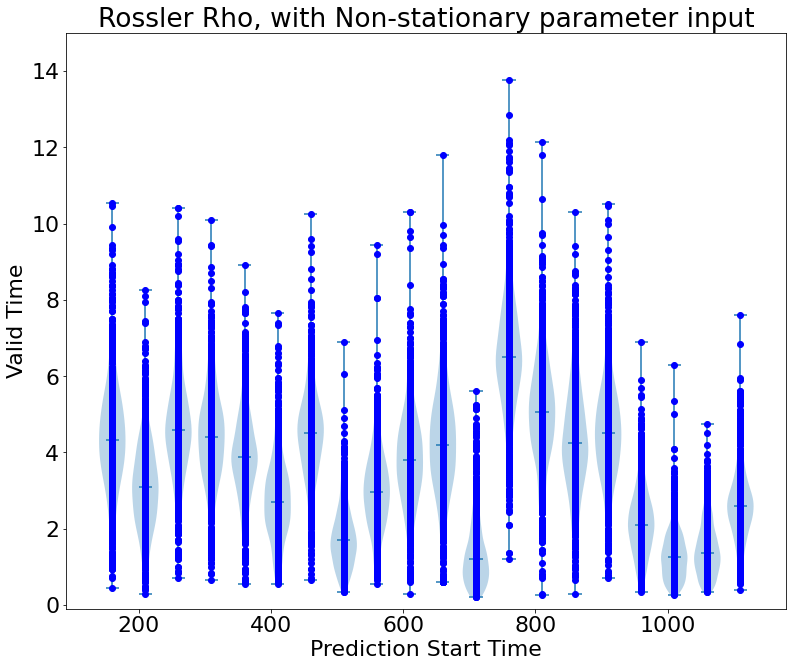

In [31]:
fig6 = plt.figure(figsize = (10,8))
ax = fig6.add_axes([0,0,1,1])
period = 500
periodic_data_extern = []
periodic_data_noextern = []
plt.rcParams.update({'font.size': 22})
for i in range(times.size):
    periodic_data_extern.append(valid_times_extern[:,i].flatten())
bp = ax.violinplot(periodic_data_extern, positions = times, showmedians = True, widths = 40)
for i in range(times.size):
    plt.plot(np.ones(valid_times_extern[:,i].flatten().size)*times[i], valid_times_extern[:,i].flatten(), 'bo')
plt.ylim([-0.1,15])
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('Rossler Rho, with Non-stationary parameter input')
plt.savefig('lorenz_rossler_VT_density_extern.png')
plt.show()

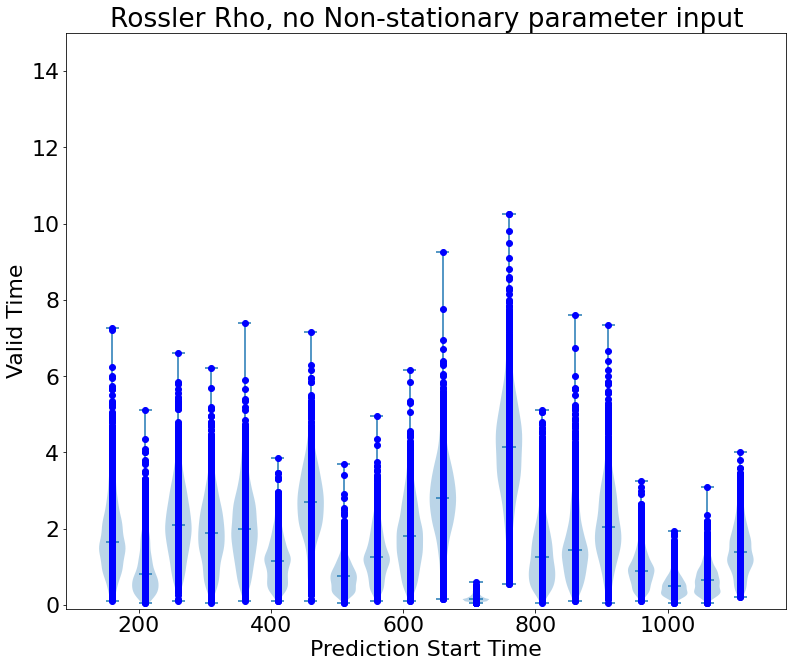

In [34]:
fig6 = plt.figure(figsize = (10,8))
ax = fig6.add_axes([0,0,1,1])
period = 500
periodic_data_extern = []
periodic_data_noextern = []
plt.rcParams.update({'font.size': 22})
for i in range(times_noextern.size):
    periodic_data_noextern.append(valid_times_noextern[:,i].flatten())
bp = ax.violinplot(periodic_data_noextern, positions = times_noextern, showmedians = True, widths = 40)
for i in range(times_noextern.size):
    plt.plot(np.ones(valid_times_noextern[:,i].flatten().size)*times_noextern[i], valid_times_noextern[:,i].flatten(), 'bo')
plt.ylim([-0.1,15])
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('Rossler Rho, no Non-stationary parameter input')
plt.savefig('lorenz_rossler_VT_density_noextern.png')
plt.show()

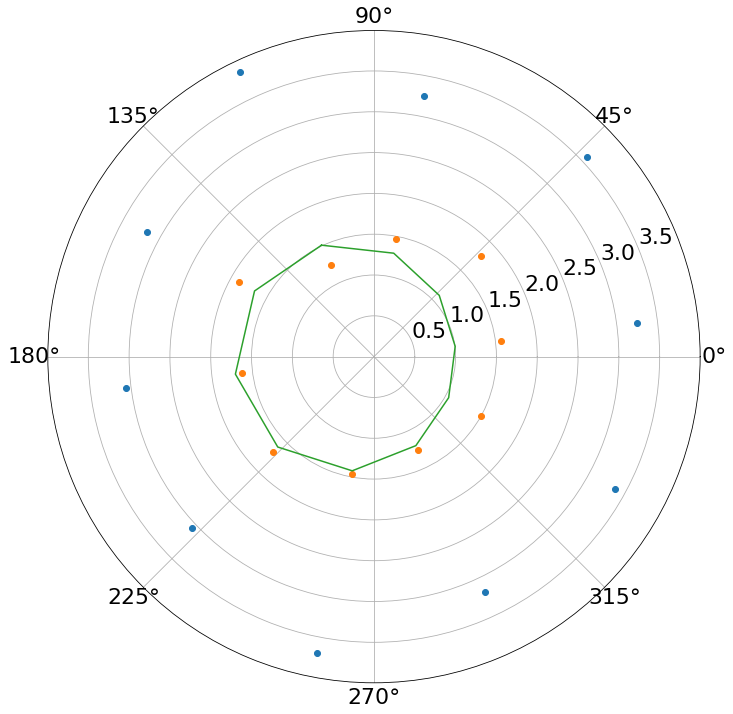

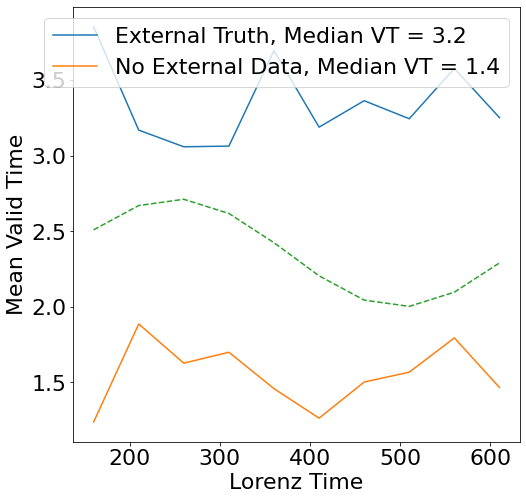

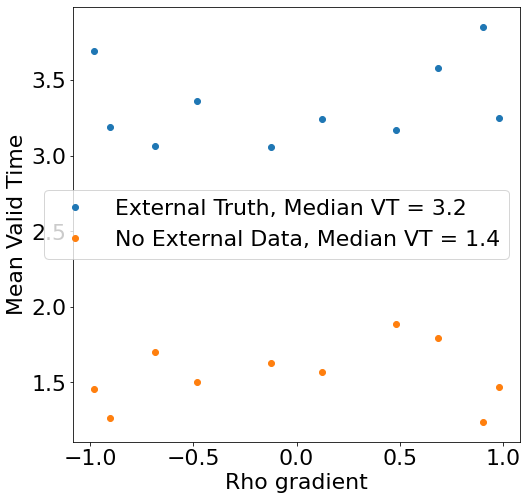

c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


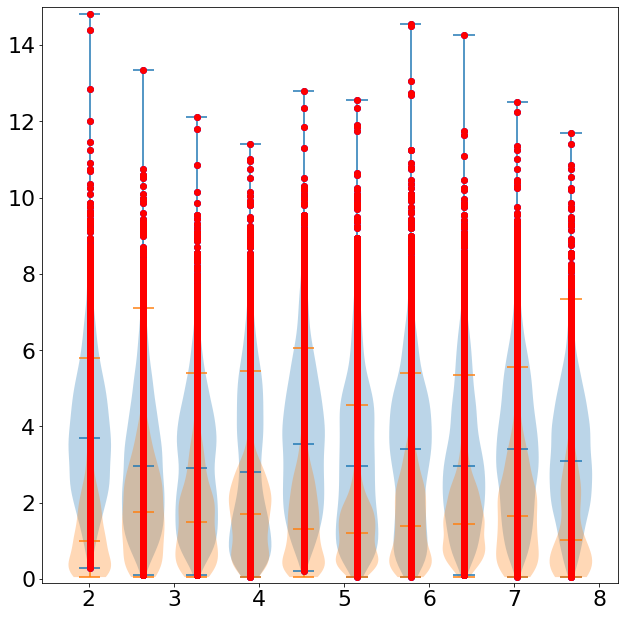

In [35]:
results_file_extern   = 'cosine_external_truth_results.csv'
results_file_noextern = 'cosine_noexternal_results.csv'
# rho_file     = 'cosine_rho.csv'
valid_times_extern  = np.loadtxt(results_file_extern, delimiter = ',')*step
extern_rows       = np.all(valid_times_extern != 0., axis = 1)
valid_times_extern  = valid_times_extern[extern_rows]
valid_times_noextern  = np.loadtxt(results_file_noextern, delimiter = ',')*step
noextern_rows         = np.all(valid_times_noextern != 0., axis = 1)
valid_times_noextern  = valid_times_noextern[noextern_rows]

median_vt_extern      = np.mean(valid_times_extern, axis = 0)
median_vt_noextern    = np.mean(valid_times_noextern, axis = 0)

num_tests    = median_vt_extern.size
init_delay   = 0
step         = 0.05
data_step    = (200000-init_delay)//num_tests
init_delay_2 = 20000
data_step_2  = (200000-init_delay)//num_tests
prepred_len  = 3000+200
times = (np.arange(num_tests)*data_step+prepred_len+init_delay)*step
times_2 = (np.arange(num_tests)*data_step_2+prepred_len+init_delay)*step
rhos  = r_t_cosine(times)
xend  = 900
"""
fig = plt.figure(figsize = (10,6))
plt.plot(times, rhos, '--', label = 'Rho')
plt.plot(times_2, median_vt_extern, label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
plt.plot(times, median_vt_noextern, label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Median Valid Time')
plt.xlim(0,xend)
plt.legend()
plt.savefig('lorenz_cosine_median_vt_wextern.png')
plt.show()

fig2 = plt.figure(figsize = (10,6))
plt.plot(times, rhos*28)
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Rho')
plt.xlim(0,xend)
plt.savefig('rho_values_cosine.png')
plt.show()
"""
period = 500
periodic_mean_extern = np.zeros(10)
periodic_mean_noextern = np.zeros(10)
for i in range(10):
    periodic_mean_extern[i] = np.mean(median_vt_extern[i::10])
    periodic_mean_noextern[i] = np.mean(median_vt_noextern[i::10])
fig3 = plt.figure(figsize = (12,12))
plt.polar(2*np.pi*times_2[:10]/500, periodic_mean_extern, 'o')
plt.polar(2*np.pi*times[:10]/500, periodic_mean_noextern, 'o')
plt.polar(2*np.pi*times[:11]/500, rhos[:11])
plt.savefig('lorenz_cosine_medianVT_polar.png')
plt.show()

fig4 = plt.figure(figsize = (8,8))
plt.plot(times[:10],  periodic_mean_extern, label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
plt.plot(times_2[:10], periodic_mean_noextern, label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.plot(times[:10], rhos[:10]+1, '--')
plt.xlabel('Lorenz Time')
plt.ylabel('Mean Valid Time')
plt.legend()
plt.savefig('lorenz_cosine_medianVT_linear.png')
plt.show()

fig4 = plt.figure(figsize = (8,8))
plt.plot(-np.sin(2*np.pi*times[:10]/500-np.pi),  periodic_mean_extern, 'o', label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
plt.plot(-np.sin(2*np.pi*times_2[:10]/500-np.pi), periodic_mean_noextern, 'o', label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Rho gradient')
plt.ylabel('Mean Valid Time')
plt.legend()
plt.savefig('lorenz_cosine_medianVT_vs_gradient.png')
plt.show()

fig6 = plt.figure(figsize = (8,8))
ax = fig6.add_axes([0,0,1,1])
period = 500
periodic_data_extern = []
periodic_data_noextern = []
for i in range(10):
    periodic_data_extern.append(valid_times_extern[:,i::10].flatten())
    periodic_data_noextern.append(valid_times_noextern[:,i::10].flatten())
bp = ax.violinplot(periodic_data_extern, positions = 2*np.pi*times_2[:10]/500, showmedians = True)
for i in range(10):
    plt.plot(np.ones(valid_times_extern[:,i::10].flatten().size)*2*np.pi*times_2[i]/500, valid_times_extern[:,i::10].flatten(), 'bo')
plt.plot()
ax2 = fig6.add_axes([0,0,1,1])
bp2 = ax.violinplot(periodic_data_noextern, positions = 2*np.pi*times[:10]/500, showmedians = True)
for i in range(10):
    plt.plot(np.ones(valid_times_extern[:,i::10].flatten().size)*2*np.pi*times_2[i]/500, valid_times_extern[:,i::10].flatten(), 'ro')
plt.ylim([-0.1,15])
plt.show()

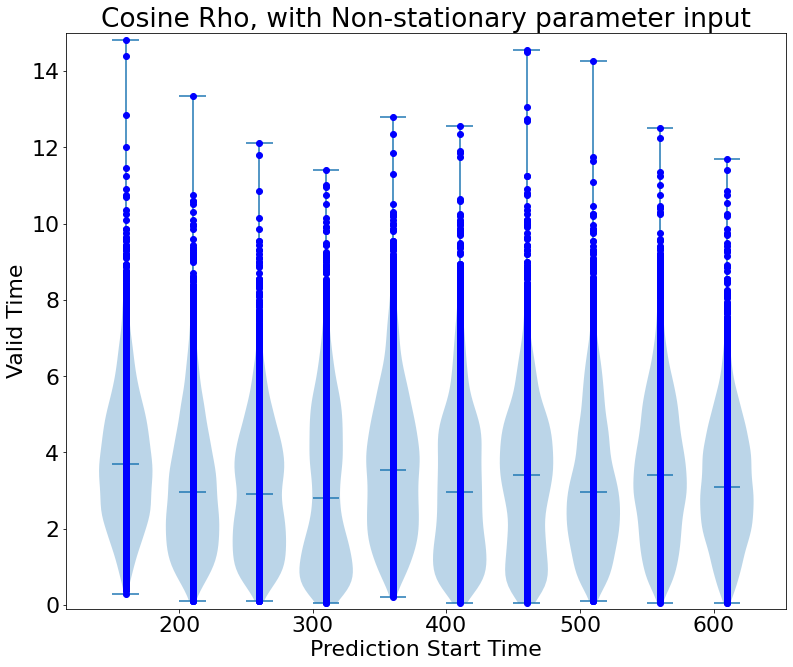

In [36]:
fig6 = plt.figure(figsize = (10,8))
ax = fig6.add_axes([0,0,1,1])
period = 500
periodic_data_extern = []
periodic_data_noextern = []
plt.rcParams.update({'font.size': 22})
for i in range(10):
    periodic_data_extern.append(valid_times_extern[:,i::10].flatten())
bp = ax.violinplot(periodic_data_extern, positions = times_2[:10], showmedians = True, widths = 40)
for i in range(10):
    plt.plot(np.ones(valid_times_extern[:,i::10].flatten().size)*times_2[i], valid_times_extern[:,i::10].flatten(), 'bo')
plt.ylim([-0.1,15])
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('Cosine Rho, with Non-stationary parameter input')
plt.savefig('lorenz_cosine_VT_density_extern.png')
plt.show()

c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


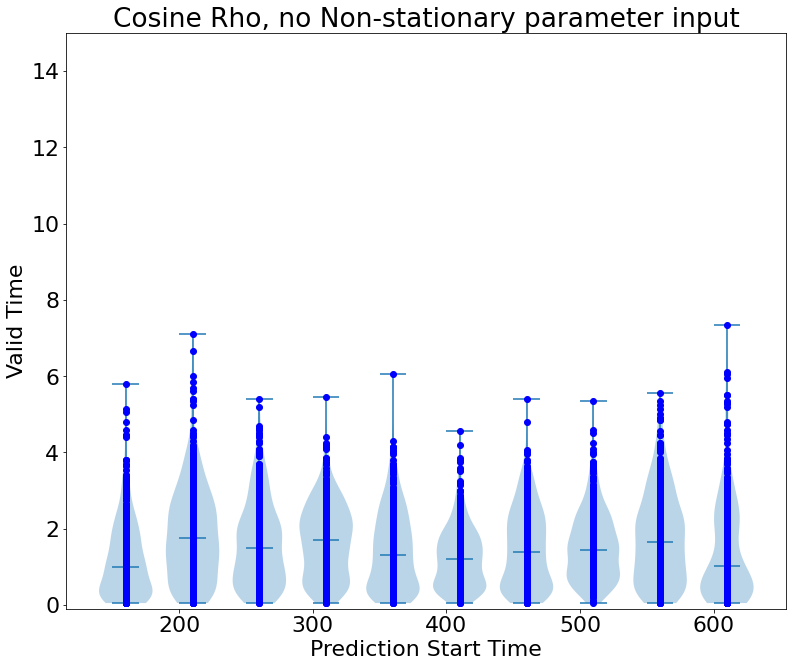

In [37]:
fig7 = plt.figure(figsize = (10,8))
ax = fig6.add_axes([0,0,1,1])
period = 500
periodic_data_extern = []
periodic_data_noextern = []
plt.rcParams.update({'font.size': 22})
for i in range(10):
    periodic_data_noextern.append(valid_times_noextern[:,i::10].flatten())
ax2 = fig7.add_axes([0,0,1,1])
bp2 = ax2.violinplot(periodic_data_noextern, positions = times[:10], showmedians = True, widths = 40)
for i in range(10):
    plt.plot(np.ones(valid_times_noextern[:,i::10].flatten().size)*times[i], valid_times_noextern[:,i::10].flatten(), 'bo')
plt.ylim([-0.1,15])
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('Cosine Rho, no Non-stationary parameter input')
plt.savefig('lorenz_cosine_VT_density_noextern.png')
plt.show()

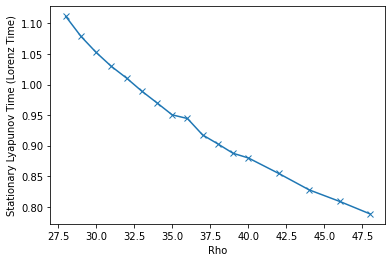

In [6]:
lyapunov_data_1 = np.loadtxt('lorenz_lyapunov_times.csv', delimiter = ',')
lyapunov_data_2 = np.loadtxt('lorenz_lyapunov_times_2.csv', delimiter = ',')
lyapunov_data   = np.vstack((lyapunov_data_1, lyapunov_data_2))

plt.plot(lyapunov_data[:,0], lyapunov_data[:,1], 'x-')
plt.xlabel('Rho')
plt.ylabel('Stationary Lyapunov Time (Lorenz Time)')
plt.savefig('lyapunov_time_vs_rho.png')
plt.show()

In [7]:
const28data = pd.read_csv('cmaes_lorenz_constrho28_res1/xmean.dat', skiprows = 2, sep = ' ', header = None).to_numpy()
const33data = pd.read_csv('cmaes_lorenz_constrho33_res1/xmean.dat', skiprows = 2, sep = ' ', header = None).to_numpy()
const38data = pd.read_csv('cmaes_lorenz_constrho38_res1/xmean.dat', skiprows = 2, sep = ' ', header = None).to_numpy()
const43data = pd.read_csv('cmaes_lorenz_constrho43_res1/xrecentbest.dat', skiprows = 2, sep = ' ', header = None).to_numpy()
const48data = pd.read_csv('cmaes_lorenz_constrho48_res1/xrecentbest.dat', skiprows = 2, sep = ' ', header = None).to_numpy()

const28fit = pd.read_csv('cmaes_lorenz_constrho28_res1/fit.dat', skiprows = 2, sep = ' ', header = None).to_numpy()
const33fit = pd.read_csv('cmaes_lorenz_constrho33_res1/fit.dat', skiprows = 2, sep = ' ', header = None).to_numpy()
const38fit = pd.read_csv('cmaes_lorenz_constrho38_res1/fit.dat', skiprows = 2, sep = ' ', header = None).to_numpy()

unnorm_VT = -1.0*step*np.array([const28fit[-1,4], const33fit[-1,4], const38fit[-1,4], const43data[-1,4], const48data[-1,4]], dtype = np.float64)
const_rhos = np.array([28,33,38,43,48])

lyapunov_interp = interp1d(lyapunov_data[:,0], lyapunov_data[:,1])
const_lyapunov  = lyapunov_interp(const_rhos)

norm_VT = unnorm_VT/const_lyapunov
best_input_weight = (np.array([const28data[-1,5], const33data[-1,5], const38data[-1,5], const43data[-1,5], const48data[-1,5]], dtype = np.float64)-5)*0.2
best_regularization = 10**(np.array([-const28data[-1,6]-3.0, -const33data[-1,6]-3.0, -const38data[-1,6]-3.0, -const43data[-1,6]-2.0, -const48data[-1,6]-2.0], dtype = np.float64))
best_leakage = 1-expit(np.array([const28data[-1,7], const33data[-1,7], const38data[-1,7], const43data[-1,7], const48data[-1,7]], dtype = np.float64)-5)
best_spectral_radius = expit(np.array([const28data[-1,8], const33data[-1,8], const38data[-1,8], const43data[-1,8], const48data[-1,8]], dtype = np.float64)-5)

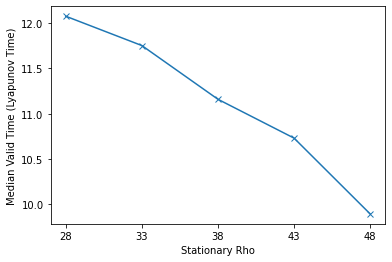

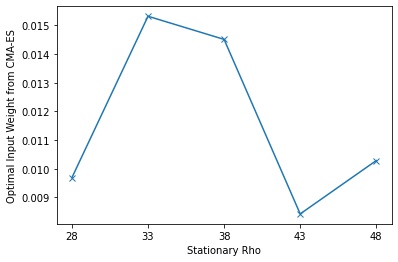

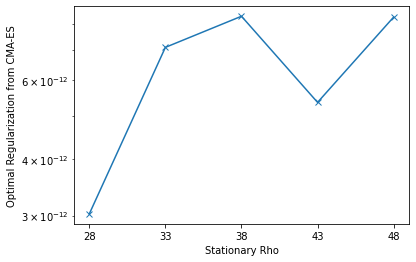

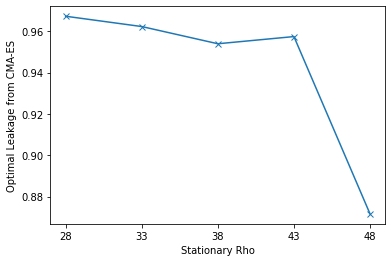

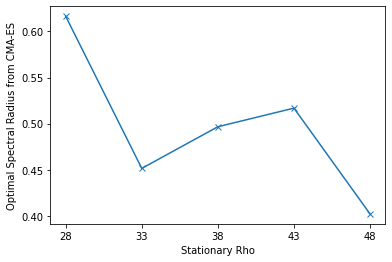

In [8]:
figa = plt.figure()
plt.plot(const_rhos, norm_VT, 'x-')
plt.xlabel('Stationary Rho')
plt.ylabel('Median Valid Time (Lyapunov Time)')
plt.xticks(np.array([28,33,38,43,48]))
plt.savefig('lorenz_const_medianVT.png')
plt.show()

figb = plt.figure()
plt.plot(const_rhos, best_input_weight, 'x-')
plt.xlabel('Stationary Rho')
plt.ylabel('Optimal Input Weight from CMA-ES')
plt.xticks(np.array([28,33,38,43,48]))
plt.savefig('lorenz_const_input_weight.png')
plt.show()

figc = plt.figure()
plt.plot(const_rhos, best_regularization, 'x-')
plt.yscale('log')
plt.xlabel('Stationary Rho')
plt.ylabel('Optimal Regularization from CMA-ES')
plt.xticks(np.array([28,33,38,43,48]))
plt.savefig('lorenz_const_reg.png')

plt.show()

figd = plt.figure()
plt.plot(const_rhos, best_leakage, 'x-')
plt.xlabel('Stationary Rho')
plt.ylabel('Optimal Leakage from CMA-ES')
plt.xticks(np.array([28,33,38,43,48]))
plt.savefig('lorenz_const_leakage.png')
plt.show()

fige = plt.figure()
plt.plot(const_rhos, best_spectral_radius, 'x-')
plt.xlabel('Stationary Rho')
plt.ylabel('Optimal Spectral Radius from CMA-ES')
plt.xticks(np.array([28,33,38,43,48]))
plt.savefig('lorenz_const_spectral.png')
plt.show()